In [1]:
# From PyG tutorial
# https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=HvhgQoO8Svw4

In [2]:
import torch
from torch_geometric.datasets import TUDataset
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [3]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Number of training graphs: 150
Number of test graphs: 38


In [4]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x, edge_index, batch = x.to(device), edge_index.to(device), batch.to(device)
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.lin(x)
        
        return x


class GCN_SVI(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_SVI, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

        #### New lines for SVI ####
        # Append pre-activation \tilde{X}_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_Xtilde = []
        # Append the grad of L w.r.t. X_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_grad = []
        self.on_training = True
        #### End #####

    #### New lines for SVI ####
    # Avoid gradient accumulation
    def turn_on_off_grad(self, on = True):
        for param in self.parameters():
            param.requires_grad = on
    #### End #####

    def append_to_layers_Xtilde(self, conv, x, edge_index = None):
        if self.on_training:
            x_tmp = x.detach().clone().to(device)
            if edge_index is None:
                self.layers_Xtilde.append(conv(x_tmp))
            else:
                self.layers_Xtilde.append(conv(x_tmp, edge_index))
    
    def append_to_layers_grad(self, x):
        if self.on_training:
            x.retain_grad()
            self.layers_grad.append(x)

    def forward(self, x, edge_index, batch):
        x, edge_index, batch = x.to(device), edge_index.to(device), batch.to(device)
        # 1. Obtain node embeddings 
        self.append_to_layers_Xtilde(self.conv1, x, edge_index)
        x = self.conv1(x, edge_index)
        x = x.relu()
        self.append_to_layers_grad(x)
        self.append_to_layers_Xtilde(self.conv2, x, edge_index)
        x = self.conv2(x, edge_index)
        x = x.relu()
        self.append_to_layers_grad(x)
        self.append_to_layers_Xtilde(self.conv3, x, edge_index)
        x = self.conv3(x, edge_index)
        self.append_to_layers_grad(x)


        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        self.append_to_layers_Xtilde(self.lin, x)
        x = self.lin(x)
        self.append_to_layers_grad(x)
        
        return x

In [5]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y.to(device))  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
         

def train_SVI():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.
        #### New lines for SVI ####
        # NOTE: lines below are necessary, as o/w model.layers_x grow in size as epoches increases
        model.layers_Xtilde = []
        model.layers_grad = []
        model.on_training = True
        #### End #####
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y.to(device))  # Compute the loss.
        model.turn_on_off_grad(on = False) 
        loss.backward()  # Derive gradients.
        #### New lines for SVI ####
        loss_tilde = 0
        for Xlplus1, Xlplus1grad in zip(model.layers_Xtilde, model.layers_grad):
            Xlplus1grad = Xlplus1grad.grad.detach().clone().to(device)
            # This is correct, I have verified it on SVI_old to give the same results
            loss_tilde += (Xlplus1*Xlplus1grad).sum() # No need to take mean any more, because loss is mean reduce
        model.turn_on_off_grad(on = True)
        loss_tilde.backward()  # To get update direction by MVI for all layers at once
        optimizer.step()  # Update parameters based on gradients.
        model.on_training = False

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y.to(device)).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [6]:
epochs = 200
learning_rate = 0.01

In [7]:
# Train SGD
model = GCN(hidden_channels=64).to(device)
train_func = train
optim = 'SGD' # 'Adam' or 'SGD'
if optim == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optim == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
else:
    raise ValueError('optim must be either Adam or SGD')
criterion = torch.nn.CrossEntropyLoss()
train_acc_list = np.zeros(epochs)
test_acc_list = np.zeros(epochs)
for epoch in range(epochs):
    train_func()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_acc_list[epoch] = train_acc
    test_acc_list[epoch] = test_acc

SGD_results = {'train_acc_list': train_acc_list, 'test_acc_list': test_acc_list}

Epoch: 000, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 007, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 008, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 009, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 011, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 012, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 013, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 014, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 015, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 016, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 017, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 018, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 019, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 020, Train Acc: 0.6467, Test Acc:

In [8]:
# Train SVI
model = GCN_SVI(hidden_channels=64).to(device)
train_func = train_SVI
if optim == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optim == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
else:
    raise ValueError('optim must be either Adam or SGD')
criterion = torch.nn.CrossEntropyLoss()
train_acc_list = np.zeros(epochs)
test_acc_list = np.zeros(epochs)
for epoch in range(epochs):
    train_func()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_acc_list[epoch] = train_acc
    test_acc_list[epoch] = test_acc

SVI_results = {'train_acc_list': train_acc_list, 'test_acc_list': test_acc_list}

Epoch: 000, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 007, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 008, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 009, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 011, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 012, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 013, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 014, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 015, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 016, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 017, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 018, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 019, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 020, Train Acc: 0.6467, Test Acc:

In [9]:
# SVI-then-SGD
import numpy as np
SGD_higher = np.where(SGD_results['train_acc_list']-SVI_results['train_acc_list']  >= 0)[0]
print(SGD_higher)
switch_epoch = SGD_higher[-1] + 1
print(f'Switch epoch from SVI to SGD = {switch_epoch}')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 134 135 136 137 138 140 145 150 151 152 155
 158 159 162 163 165 166 168 169 170 171 172 173 174 175 177 178 179 182
 183 184 185 187 188 190 191 192 193 195 196 197 199]
Switch epoch from SVI to SGD = 200


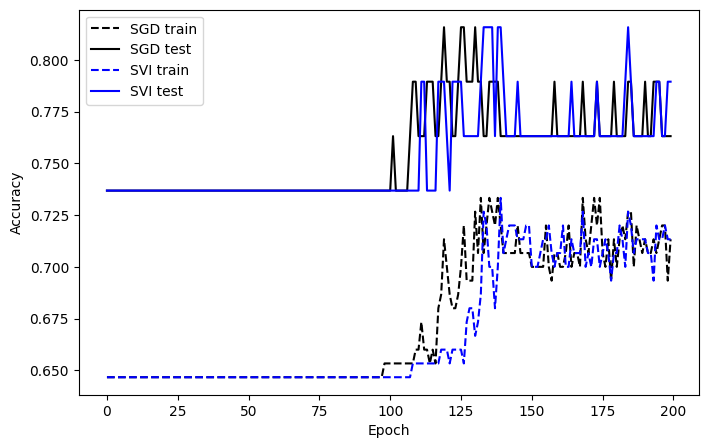

In [10]:
# 1 by 2 matplot subplots
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(SGD_results['train_acc_list'], label=f'{optim} train', color='black', linestyle='dashed')
ax.plot(SGD_results['test_acc_list'], label=f'{optim} test', color = 'black')
ax.plot(SVI_results['train_acc_list'], label='SVI train', color='blue', linestyle='dashed')
ax.plot(SVI_results['test_acc_list'], label='SVI test', color='blue')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()